<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nprivaul/mc-odes/blob/main/mc_odes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Imports & basic configuration

In [1]:
import time
import math
import torch
from scipy import special
from torch.distributions.exponential import Exponential
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Sun Jun  8 11:07:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               Off |   00000000:21:00.0  On |                  Off |
| 41%   50C    P8             20W /  140W |    4267MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------

In [3]:
# Author: Jiang Yu Nguwi

torch.manual_seed(0)  # set seed for reproducibility

class ODEBranch(torch.nn.Module):
    def __init__(
        self,
        fun,
        t_lo=0.0,
        t_hi=1.0,
        x0=1.0,
        nb_paths_per_point=2000000,
        nb_points=6,
        outlier_percentile=1,
        outlier_multiplier=1000,
        patch=1,
        epochs=3000,
        device="cpu",
        verbose=False,
        **kwargs,
    ):
        super(ODEBranch, self).__init__()
        self.fun = fun

        self.loss = torch.nn.MSELoss()
        self.nb_paths_per_point = nb_paths_per_point
        self.nb_points = nb_points
        self.outlier_percentile = outlier_percentile
        self.outlier_multiplier = outlier_multiplier
        self.patch = patch
        self.t_lo = t_lo
        self.t_hi = t_hi
        self.x0 = x0
        self.dim = len(x0)
        self.epochs = epochs
        self.device = device
        self.verbose = verbose

    def forward(self, code=None):
        start = time.time()
        code = [-1] * self.dim if code is None else code  # start from identity code if not specified
        t = torch.linspace(self.t_lo, self.t_hi, steps=self.nb_points, device=self.device)
        t = t.repeat(self.nb_paths_per_point).reshape(self.nb_paths_per_point, -1).T
        nb_points_per_patch = math.ceil(self.nb_points / self.patch)
        cur_start_idx, cur_end_idx = 0, nb_points_per_patch
        mc_mean, mc_var = [], []
        x0, t0 = torch.tensor(self.x0, device=self.device), torch.tensor(self.t_lo, device=self.device)
        while cur_start_idx < cur_end_idx:
            self.code_to_fun_dict = {}
            t_this_patch = t[cur_start_idx:cur_end_idx]
            H_tensor = torch.ones_like(t_this_patch)
            mask_tensor = torch.ones_like(t_this_patch)
            mc_mean_this_patch = []
            mc_var_this_patch = []
            for i in range(self.dim):
                y = self.gen_sample_batch(
                    t_this_patch,
                    t0,
                    x0,
                    np.array(code),
                    H_tensor,
                    mask_tensor,
                    coordinate=i
                )
                # widen (outlier_percentile, 1 - outlier_percentile) by outlier_multiplier times
                # everything outside this range is considered outlier
                lo = y.nanquantile(self.outlier_percentile/100, dim=1, keepdim=True)
                hi = y.nanquantile(1 - self.outlier_percentile/100, dim=1, keepdim=True)
                lo, hi = lo - self.outlier_multiplier * (hi - lo), hi + self.outlier_multiplier * (hi - lo)
                mask = torch.logical_and(lo <= y, y <= hi)
                mc_mean_this_patch.append((y * mask).sum(dim=1) / mask.sum(dim=1))
                y = y - mc_mean_this_patch[-1].unsqueeze(dim=-1)
                mc_var_this_patch.append(torch.square(y * mask).sum(dim=1) / mask.sum(dim=1))

            # update x0, t0, idx
            mc_mean.append(torch.stack(mc_mean_this_patch))
            mc_var.append(torch.stack(mc_var_this_patch))
            x0, t0 = mc_mean[-1][:, -1], t_this_patch[-1][-1]
            cur_start_idx, cur_end_idx = cur_end_idx, min(cur_end_idx + nb_points_per_patch, self.nb_points)

        if self.verbose:
            print(f"Time taken for the simulations: {time.time() - start:.2f} seconds.")
        return t[:, 0], torch.cat(mc_mean, dim=-1), torch.cat(mc_var, dim=-1)

    @staticmethod
    def nth_derivatives(order, y, x):
        """
        calculate the derivatives of y wrt x with order `order`
        """
        for cur_dim, cur_order in enumerate(order):
            for _ in range(int(cur_order)):
                try:
                    grads = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
                except RuntimeError as e:
                    # when very high order derivatives are taken for polynomial function
                    # it has 0 gradient but torch has difficulty knowing that
                    # hence we handle such error separately
                    # logging.debug(e)
                    return torch.zeros_like(y)

                # update y
                y = grads[cur_dim]
        return y

    def code_to_function(self, code, t, x0, coordinate):
        code = tuple(code)
        if (code, coordinate) not in self.code_to_fun_dict.keys():
            # code (-1, -1, ..., -1) -> identity mapping
            if code == (-1,) * self.dim:
                self.code_to_fun_dict[(code, coordinate)] = x0[coordinate]
            else:
                y = x0.clone().requires_grad_(True)
                self.code_to_fun_dict[(code, coordinate)] = (
                    self.nth_derivatives(code, self.fun(y, coordinate), y).detach()
                )
        return self.code_to_fun_dict[(code, coordinate)]

    def gen_sample_batch(self, t, t0, x0, code, H, mask, coordinate):
        nb_points, _ = t.shape
        tau = Exponential(
            lbd * torch.ones(nb_points, self.nb_paths_per_point, device=self.device)
        ).sample()
        ans = torch.zeros_like(t)

        ############################### for t + tau >= T
        mask_now = mask.bool() * (t0 + tau >= t)
        if mask_now.any():
            ans[mask_now] = (
                    H[mask_now]
                    * self.code_to_function(code, t0, x0, coordinate)
                    / torch.exp(- lbd * (t - t0)[mask_now])
            )

        ############################### for t + tau < T
        mask_now = mask.bool() * (t0 + tau < t)
        if (code == [-1] * self.dim).all():
            if mask_now.any():
                # code (-1, -1,..., -1) -> (0, 0,..., 0)
                tmp = self.gen_sample_batch(
                    t - tau, t0, x0, code + 1, H / lbd / torch.exp(-lbd * tau), mask_now, coordinate,
                )
                ans = ans.where(~mask_now, tmp)

        else:
            unif = torch.rand(nb_points, self.nb_paths_per_point, device=self.device)
            idx = (unif * self.dim).long()
            for i in range(self.dim):
                mask_tmp = mask_now * (idx == i)
                if mask_tmp.any():
                    A = self.gen_sample_batch(
                        t - tau,
                        t0,
                        x0,
                        np.array([0] * self.dim),
                        torch.ones_like(t),
                        mask_tmp,
                        i,
                    )
                    code[i] += 1
                    tmp = self.gen_sample_batch(
                        t - tau,
                        t0,
                        x0,
                        code,
                        self.dim * A * H / lbd / torch.exp(-lbd * tau),
                        mask_tmp,
                        coordinate,
                    )
                    code[i] -= 1
                    ans = ans.where(~mask_tmp, tmp)
        return ans

Time taken for the simulations: 1.10 seconds.
For coordinate 1:
Variance of MC is tensor([0.00e+00, 5.11e-13, 3.55e-13, 3.57e-13, 5.75e-02, 9.11e-02, 1.39e-01,
        3.57e-01, 7.31e-01, 9.91e-01, 2.73e-02, 9.69e-02, 1.98e-01, 1.11e+00,
        4.59e+00, 8.52e+00, 1.72e+01, 3.53e+01, 6.87e+01, 7.80e+01],
       device='cuda:0').
Squared error is tensor([0.00e+00, 8.55e-08, 1.51e-06, 8.40e-06, 9.98e-08, 1.85e-07, 7.06e-07,
        2.10e-07, 2.86e-08, 1.34e-07, 3.28e-07, 8.65e-07, 1.07e-05, 6.87e-06,
        7.53e-06, 4.38e-05, 2.39e-04, 9.75e-04, 3.56e-03, 2.36e-02],
       device='cuda:0').


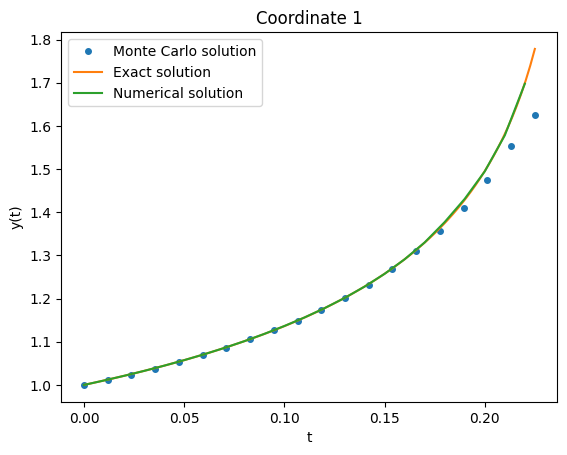

In [4]:
dim = 1
problem = "power nonlinearity"
n = 5 
lbd = 1 

exact_fun = (lambda t, y, coordinate: 1 / ( y[coordinate] ** (1 - n)  - (n - 1 ) * t ) ** (1/(n-1)))
             
# y[coordinate] / (1 - y[coordinate] * t))
# 1 / (t - n * t + y[coordinate] ** (1 - n)) ** (1/(n-1))

f_fun = (lambda y, coordinate: y[coordinate] ** n)
x0 = [1.0] * dim
t_lo, t_hi = 0, 0.9 * x0[0] ** (1 - n) / (n - 1 )  
nb_points = 20
F = lambda t, y: y ** n

# initialize model and calculate mc samples
model = ODEBranch(
    f_fun,
    t_lo=t_lo,
    t_hi=t_hi,
    x0=x0,
    device=device,
    nb_points=nb_points,
    verbose=True,
    patch=2,
    outlier_percentile=0.1,
    outlier_multiplier=100,
    )

t, mc_mean, mc_var = model()
t_fine = torch.linspace(t_lo, t_hi, 100, device=device)  # finer grid for plotting exact solution
torch.set_printoptions(precision=2, sci_mode=True)
t_eval = np.arange(t_lo, t_hi, 0.01)
sol = solve_ivp(F, [t_lo, t_hi], [x0[0]], t_eval=t_eval)

# plot exact vs numerical
for i in range(model.dim):
    print(f"For coordinate {i + 1}:")
    print(f"Variance of MC is {mc_var[i]}.")
    print(f"Squared error is {(mc_mean[i] - exact_fun(t, x0, i)) ** 2}.")
    plt.plot(t.cpu(), mc_mean[i].cpu(), 'o', markersize=4, label="Monte Carlo solution")
    plt.plot(t_fine.cpu(), exact_fun(t_fine, x0, i).cpu(), label="Exact solution")
    plt.plot(sol.t, sol.y[0], label="Numerical solution")
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title(f"Coordinate {i + 1}")
    plt.legend()
    plt.show()


Time taken for the simulations: 1.14 seconds.
For coordinate 1:
Variance of MC is tensor([0.00e+00, 5.82e-02, 1.34e-01, 2.54e-01, 4.02e-01, 6.99e-01, 8.93e-01,
        1.51e+00, 2.23e+00, 3.65e+00, 2.61e-01, 8.59e-01, 2.13e+00, 5.85e+00,
        8.61e+00, 1.73e+01, 3.23e+01, 4.87e+01, 2.08e+02, 3.27e+02],
       device='cuda:0').
Squared error is tensor([0.00e+00, 1.26e-08, 4.03e-08, 1.33e-08, 3.29e-08, 1.22e-06, 8.92e-07,
        6.84e-08, 1.10e-07, 3.68e-10, 1.22e-07, 1.54e-06, 2.30e-06, 2.64e-06,
        3.53e-05, 2.09e-04, 4.99e-04, 3.67e-03, 8.57e-03, 4.81e-02],
       device='cuda:0').


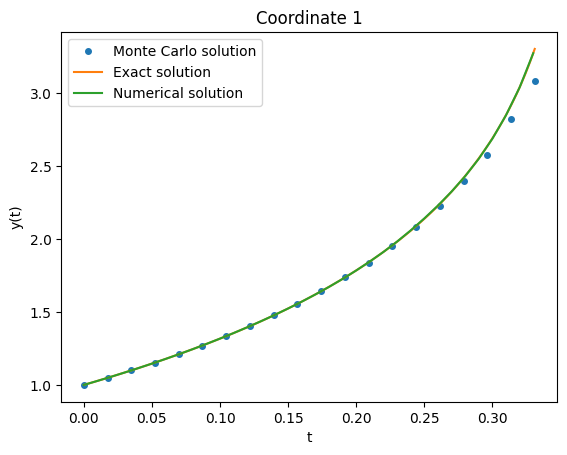

In [5]:
dim = 1
problem = "exponential nonlinearity"
lbd = 1 

def exact_fun(t, y, coordinate): 
    return - torch.log( np.exp(- y[coordinate]) - t ) # *torch.cos(0)

f_fun = (lambda y, coordinate: torch.exp(y[coordinate]))
x0 = [1.0] * dim
t_lo, t_hi = 0, 0.9 * np.exp(-x0[0])  
nb_points = 20
F = lambda t, y: np.exp(y)

# initialize model and calculate mc samples
model = ODEBranch(
    f_fun,
    t_lo=t_lo,
    t_hi=t_hi,
    x0=x0,
    device=device,
    nb_points=nb_points,
    verbose=True,
    patch=2,
    outlier_percentile=0.1,
    outlier_multiplier=100,
    )

t, mc_mean, mc_var = model()
t_fine = torch.linspace(t_lo, t_hi, 100, device=device)  # finer grid for plotting exact solution
torch.set_printoptions(precision=2, sci_mode=True)
t_eval = np.arange(t_lo, t_hi, 0.01)
sol = solve_ivp(F, [t_lo, t_hi], [x0[0]], t_eval=t_eval)

# plot exact vs numerical
for i in range(model.dim):
    print(f"For coordinate {i + 1}:")
    print(f"Variance of MC is {mc_var[i]}.")
    print(f"Squared error is {(mc_mean[i] - exact_fun(t, x0, i)) ** 2}.")
    plt.plot(t.cpu(), mc_mean[i].cpu(), 'o', markersize=4, label="Monte Carlo solution")
    plt.plot(t_fine.cpu(), exact_fun(t_fine, x0, i).cpu(), label="Exact solution")
    plt.plot(sol.t, sol.y[0], label="Numerical solution")
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title(f"Coordinate {i + 1}")
    plt.legend()
    plt.show()

Time taken for the simulations: 20.28 seconds.
For coordinate 1:
Variance of MC is tensor([0.00e+00, 3.48e-02, 9.77e-02, 1.95e-01, 3.33e-01, 5.19e-01, 7.63e-01, 1.09e+00, 1.51e+00, 2.08e+00, 1.46e-01, 3.21e-01,
        5.29e-01, 7.72e-01, 1.06e+00, 1.39e+00, 1.76e+00, 2.21e+00, 2.72e+00, 3.31e+00],
       device='cuda:0').
Squared error is tensor([3.55e-15, 3.81e-09, 6.20e-08, 6.19e-11, 8.65e-07, 4.13e-07, 3.98e-07,
        3.47e-07, 2.35e-09, 9.23e-08, 6.51e-07, 1.45e-07, 1.88e-10, 1.74e-08,
        1.05e-06, 2.25e-07, 3.67e-07, 2.94e-07, 2.55e-07, 1.44e-06],
       device='cuda:0').


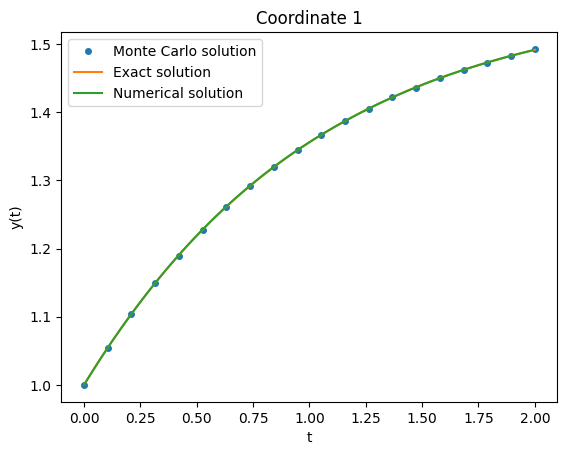

In [6]:
dim = 1
        
problem = "cosine"
def exact_fun(t, y, coordinate):
    return 2 * torch.atan(torch.tanh((t + 2 * math.atanh(math.tan(y[coordinate] / 2))) / 2))
f_fun = (lambda y, coordinate: torch.cos(y[coordinate]))
t_lo, t_hi = 0, 2.0
x0 = [1.0] * dim
nb_points = 20
F = lambda t, y: np.cos(y)

# initialize model and calculate mc samples
model = ODEBranch(
    f_fun,
    t_lo=t_lo,
    t_hi=t_hi,
    x0=x0,
    device=device,
    nb_points=nb_points,
    verbose=True,
    patch=2,
    outlier_percentile=0.1,
    outlier_multiplier=100,
    )

t, mc_mean, mc_var = model()
t_fine = torch.linspace(t_lo, t_hi, 100, device=device)  # finer grid for plotting exact solution
torch.set_printoptions(precision=2, sci_mode=True)
t_eval = np.arange(t_lo, t_hi, 0.01)
sol = solve_ivp(F, [t_lo, t_hi], [x0[0]], t_eval=t_eval)

# plot exact vs numerical
for i in range(model.dim):
    print(f"For coordinate {i + 1}:")
    print(f"Variance of MC is {mc_var[i]}.")
    print(f"Squared error is {(mc_mean[i] - exact_fun(t, x0, i)) ** 2}.")
    plt.plot(t.cpu(), mc_mean[i].cpu(), 'o', markersize=4, label="Monte Carlo solution")
    plt.plot(t_fine.cpu(), exact_fun(t_fine, x0, i).cpu(), label="Exact solution")
    plt.plot(sol.t, sol.y[0], label="Numerical solution")
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title(f"Coordinate {i + 1}")
    plt.legend()
    plt.show()


Time taken for the simulations: 20.13 seconds.
For coordinate 1:
Variance of MC is tensor([0.00e+00, 3.05e-02, 8.15e-02, 1.60e-01, 2.71e-01, 4.31e-01, 6.55e-01, 9.83e-01, 1.54e+00, 3.09e+00, 1.51e-01, 3.37e-01,
        5.61e-01, 8.30e-01, 1.15e+00, 1.53e+00, 1.99e+00, 2.57e+00, 3.38e+00, 5.02e+00],
       device='cuda:0').
Squared error is tensor([0.00e+00, 3.14e-03, 1.19e-02, 2.53e-02, 4.30e-02, 6.22e-02, 8.41e-02, 1.07e-01, 1.28e-01, 1.49e-01, 1.69e-01, 1.88e-01,
        2.06e-01, 2.21e-01, 2.34e-01, 2.48e-01, 2.59e-01, 2.66e-01, 2.76e-01, 2.84e-01],
       device='cuda:0').


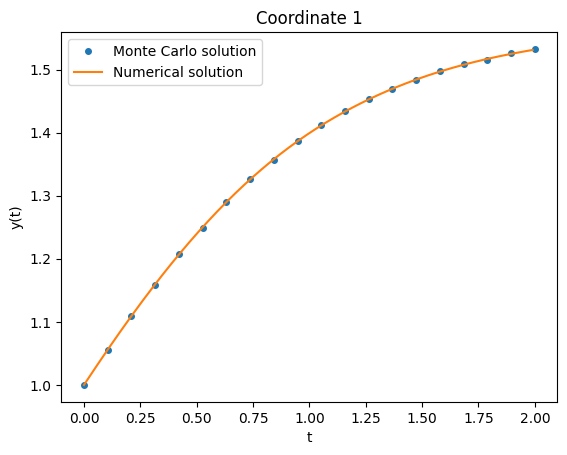

In [7]:
dim = 1
      
problem = "cosine2"
def exact_fun(t, y, coordinate):
    return x0[0]+0*torch.tan(t)
f_fun = (lambda y, coordinate: y[coordinate] * torch.cos(y[coordinate]))
t_lo, t_hi = 0, 2.0
x0 = [1.0] * dim
nb_points = 20
F = lambda t, y: y * np.cos(y)

# initialize model and calculate mc samples
model = ODEBranch(
    f_fun,
    t_lo=t_lo,
    t_hi=t_hi,
    x0=x0,
    device=device,
    nb_points=nb_points,
    verbose=True,
    patch=2,
    outlier_percentile=0.1,
    outlier_multiplier=100,
    )

t, mc_mean, mc_var = model()
t_fine = torch.linspace(t_lo, t_hi, 100, device=device)  # finer grid for plotting exact solution
torch.set_printoptions(precision=2, sci_mode=True)
t_eval = np.arange(t_lo, t_hi, 0.01)
sol = solve_ivp(F, [t_lo, t_hi], [x0[0]], t_eval=t_eval)

# plot exact vs numerical
for i in range(model.dim):
    print(f"For coordinate {i + 1}:")
    print(f"Variance of MC is {mc_var[i]}.")
    print(f"Squared error is {(mc_mean[i] - exact_fun(t, x0, i)) ** 2}.")
    plt.plot(t.cpu(), mc_mean[i].cpu(), 'o', markersize=4, label="Monte Carlo solution")
    # lt.plot(t_fine.cpu(), exact_fun(t_fine, x0, i).cpu(), label="Exact solution")
    plt.plot(sol.t, sol.y[0], label="Numerical solution")
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title(f"Coordinate {i + 1}")
    plt.legend()
    plt.show()